## Estimation of subjective income risk profile using SCE data


- This notebook does the estimation of the Markov switching model for income risk perceptions using data from SCE 
- parameters to estimate:
   - $\tilde \Gamma_l$ and $\tilde \Gamma_h$ 
   - transition matrix $\Omega$ with $p$ and $q$ as the staying probability in low and high risk states, respectively.
  - where $\tilde \Gamma_l = \{\tilde \sigma^l_\psi,\tilde \sigma^l_\theta, \tilde{\mho^l}, \tilde{E^l}\}$ and $\tilde \Gamma_h = \{\tilde \sigma^h_\psi,\tilde \sigma^h_\theta, \tilde{\mho^h}, \tilde{E^h}\}$ where we impose the restriction that $\tilde \sigma^h_\psi > \tilde \sigma^l_\psi$ and $\tilde \sigma^h_\theta > \tilde \sigma^l_\theta$, $\tilde{\mho^h}>\tilde{\mho^l}$, and $\tilde{E^h}<\tilde{E^l}$.
 
  
Possible extensions (not implemented yet)
- Specific to group, such as to age and education. 
- Conditional on macroeconomic cycles or labor market tightness

In [1]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

from Utility import mkv2_M2Q, mkv2_Y2Q

In [2]:
class Markov2Switching:
    """
    A class that stores primitives for the Markov Regime Switching Model
    %%%% Model %%%%%%%
    % y_t = alpha+ beta * s_t + epsilon_t
    % y is the observed variable;
    % s_t =1 in high state; s_t = 0 in low state;
    % q=p(s_t=0|s_t-1=0)
    % p=p(s_t=1|s_t-1=1)
    % Transition Matrix from [s=0,s=1]' is [q,1-p;1-q,p] 
    % para_est stores all estimates of parameters. 
    %%%%%%%%%%%%%%%%%

    """

    def __init__(self,
                 Y = None,
                 paras = np.array([0.1,0.1,0.1,0.7,0.7]),
                 nb_var = 1,
                 state_dependence = False,
                 AR = 0):  
        
        ## count how many variables 
        self.nb_var = nb_var
        
        if AR==0:
            assert self.nb_var == int(len(paras)/5),'the nb of parameters needs to be equal to 5 x nb of variables'
        elif AR==1:
            assert self.nb_var == int(len(paras)/6),'the nb of parameters needs to be equal to 6 x nb of variables'
          
        self.paras = paras.reshape(self.nb_var,-1)
        
        self.Y = Y
        ## be careful with the order 
        self.αs = self.paras[:,0]
        self.βs = self.paras[:,1]
        self.σs = self.paras[:,2]
        self.qs = self.paras[:,3]
        self.ps = self.paras[:,4]
        if AR==0:
            self.ϕ1s =np.zeros(self.nb_var)
        elif AR==1:
            self.ϕ1s = self.paras[:,5]
        self.state_dependence = state_dependence
        self.AR = AR 
    
    ### pdf function of normal distribution 
    def norm_pdf(self,
                 x,    ## value of the rm 
                 μ,    ## mean of the normal
                 σ):   ## std of the normal 
        """
        pdf of normal distribution mean μ and variance σ^2
        """
        x_new = (x-μ)/σ
        temp1 = 1/(np.sqrt(2*np.pi))
        temp2 = np.exp(-(x_new**2/2))
        return temp1*temp2 
    
    ## The functions below are help functions 
    ## that turn a hard constraint for parameters to an unconstrained problem
    ## prob_func  from R -> [0,1]
    def prob_func(self,
                   x):
        """
        this bound function maps unconstrained x to y between 0, and 1
        , and it increases with x
        """
        return np.exp(x)/(1+np.exp(x))     
    
    def prob_func_inv(self,
                     y):
        return np.log(y)-np.log(1-y)
    
    ## exp_func  from R --> [0,+infinity]
    def exp_func(self,
                 x):
        return np.exp(x)
    
    def exp_func_inv(self,
                     y):
        return np.log(y)
    
    def get_model_para(self,
                      para):
        """
        unconstrained parameters recast into model parameters with constraints
        """
        assert len(para)==self.nb_var*(5+self.AR),"the nb of parameters is incorrect"
        paras = para.reshape(self.nb_var,-1)
        
        αs = paras[:,0]
        βs = paras[:,1]
        #np.concatenate([self.exp_func(paras[0:2,1]),
        #                     np.array(-self.exp_func([paras[2,1]]))
        #                    ])
        σs = self.exp_func(paras[:,2])
        qs = self.prob_func(paras[:,3])
        ps = self.prob_func(paras[:,4])
        if self.AR==1:
            ϕ1s = self.prob_func(paras[:,5])
        else:
            ϕ1s = np.zeros(self.nb_var)
        return αs,βs,σs,qs,ps,ϕ1s
    
    def make_para_dict(self,
                      para):
        """
        a function that creates a dictionary of parameters with names
        """
        αs,βs,σs,qs,ps,ϕ1s =self.get_model_para(para)
            
        q = qs[0]
        p =ps[0]
        
        model_para ={}
        model_para['q']=q
        model_para['p']=p
        model_para['α']=αs
        model_para['β']=βs
        model_para['σ'] =σs
        model_para['ϕ1']=ϕ1s
                   
        return model_para
    
    def steady_state(self,
                      q,
                      p):
        """
        a function that computes the ss of a 2-state markov 
        """
        return ((1-p)/(2-p-q),
                (1-q)/(2-p-q))
    
    
    ## The key function that computes log-likelihood for a list of time series of realized data
    def log_likelihood(self,
                       Y_list,   ## a list of multiple series 
                       para):
        
        """
        inputs
        ======
        Y: a list of independent univariate/multivariate (a vector) time series for which the log-likelihood is computed jointly
        para: parameters of the process sized of nb of variables x nb of parameters, with the strict order of α,β,σ,q,p,ϕ1
        
        outputs
        =======
        llh_tot: total log-likelihood across all series
        update1_list: list of updating probs s=1|Y_t at time t;
        prdict1_list: list of prediction probs: s=1|Y_t-1 at time t-1;
        f1_list: list of predicted probs: y_t|y_t-1;
        """
        αs,βs,σs,qs,ps,ϕ1s = self.get_model_para(para)

        update1_list =[]
        prdict1_list =[]
        f1_list =[]
        
        
        ## starting from zero loglikelihood 
        
        llh_tot = 0.0

        q = qs[0]
        p = ps[0]
        
        for k in range(len(Y_list)):
            Y = Y_list[k]  ## Y is a 1-d or nb_var-d array 
            
            T = Y_list[k].shape[1] ## length of the series is not necessarily the same 
            
            ## this loops over all periods 
            llh = 0.0

            update0 = np.empty(T)
            update1 = np.empty(T)
            prdict1 = np.empty(T)
            f1 = np.empty(T)

            ## initialize the first period
            update0[0], update1[0] = self.steady_state(q,   #p(s=0|Y_0) and  # p(s=1|Y_1)
                                                       p)   
            
            for t in range(1,T-1):
                prdict1[t] = (1-q)*update0[t-1]+p*update1[t-1]  #p(s_t=1|y_t-1);
                
                pdf_t_1 = prdict1[t]
                pdf_t_0 = (1-prdict1[t])
                
                ## loop over different time series
                for x in range(self.nb_var):
                    pdf_t_1 =pdf_t_1*self.norm_pdf(Y[x,t]-ϕ1s[x]*Y[x,t-1],αs[x]+βs[x],σs[x])  # f(y_t|s_t=1,Y_t-1)
                    pdf_t_0 =pdf_t_0*self.norm_pdf(Y[x,t]-ϕ1s[x]*Y[x,t-1],αs[x],σs[x]) # f(y_t|s_t=0,Y_t-1)
                
                f1[t]= pdf_t_1+pdf_t_0     # f1= f(y_t|Y_t-1)
                #print(f1[t])
                llh_pred = np.log(f1[t])     # log( f(y_t|Y_t-1))
                llh = llh + llh_pred         # llh_pred = log(f(y_t|Y_t-1))
                update1[t] = pdf_t_1/(pdf_t_1+ pdf_t_0)  # p(s_t=0|y_t-1) 
                update0[t] = 1-update1[t]                # p(s_t=1|y_t-1)
                
            ## merge those probabilities 
            
            update1_list.append(update1) 
            prdict1_list.append(prdict1)
            f1_list.append(f1)
        
            ## sum across agents 
            llh_tot = llh_tot+llh
        
        return llh_tot,update1_list,prdict1_list,f1_list

In [3]:
## create the model 
mkv2 = Markov2Switching(AR=0,
                        nb_var=1)

### Test using fake simulated data with known parameters

In [4]:
import quantecon as qe
from quantecon import MarkovChain

## fake parameters 
α_fake = 0.1
β_fake = 0.2
σ_fake = 0.1
q_fake = 0.7
p_fake = 0.6
ϕ1_fake = 0.0

mkv_mat = np.array([[q_fake,1-q_fake],
                    [1-p_fake,p_fake]])

para_fake = np.array([α_fake,
                      β_fake,
                      mkv2.exp_func_inv(σ_fake),
                      mkv2.prob_func_inv(q_fake),
                      mkv2.prob_func_inv(p_fake),
                      #mkv2.prob_func_inv(ϕ1_fake)
                     ])
T_fake = 12
nb_sim = 300

fake_regime_h_list=[]
fake_data_list = []

prob_ss0, prob_ss1 = mkv2.steady_state(q_fake,
                                       p_fake)

init_sim = (np.random.uniform(0,1,nb_sim)<=prob_ss1)*1

for i in range(nb_sim):
    mc = qe.MarkovChain(mkv_mat)
    regime_h = mc.simulate(ts_length=T_fake+1,
                          init= init_sim[i])
    regime_l = 1-regime_h
    shocks = np.random.randn(T_fake+1)*σ_fake
    constant_l = α_fake
    constant_h = α_fake+β_fake
    y = (regime_l*constant_l+regime_h*constant_h)+shocks
    ## AR1 process
    for t in range(1,T_fake):
        y[t]= ϕ1_fake*y[t-1]+y[t]
    
    ## add to the list 
    this_y_2d = y[1:].reshape(-1,len(y[1:]))
    fake_data_list.append(this_y_2d)
    fake_regime_h_list.append(regime_h)
index = range(T_fake)

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


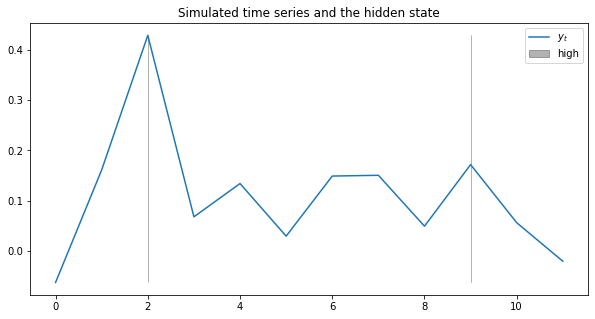

In [5]:
## plot the simulated data 
if len(fake_data_list)==1:
    random_id = 0
else:
    random_id = np.random.randint(0,len(fake_data_list)-1)
    
## get the random data and regime sequence
y = fake_data_list[random_id].T
regime_h = fake_regime_h_list[random_id]

plt.figure(figsize=(10,5))
plt.title('Simulated time series and the hidden state')
plt.plot(y,
         label=r'$y_t$')
plt.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
plt.legend(loc=1)

In [6]:
## plot log-likelihood based on the true parameters 

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_fake)

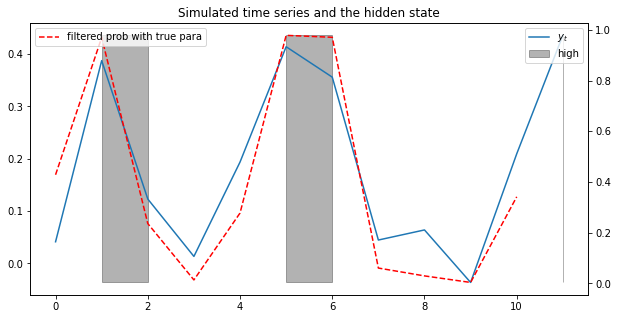

In [7]:
## plot the simulated data 
if len(fake_data_list)==1:
    random_id = 0
else:
    random_id = np.random.randint(0,len(fake_data_list)-1)
    
## get the random data and regime sequence
y = fake_data_list[random_id].T
regime_h = fake_regime_h_list[random_id]


## plot everything 
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Simulated time series and the hidden state')

## time series of y 
ax.plot(y,
         label=r'$y_t$')
## regime 
ax.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
ax2 = ax.twinx()
## filter prob
ax2.plot(filter1[random_id][:-1],
         'r--',
        label='filtered prob with true para')
ax.legend(loc=1)
ax2.legend(loc=2)

In [8]:
## try estimation

obj = lambda para: -mkv2.log_likelihood(fake_data_list,
                                        para)[0]   ## only the first output


## tight bounds for some parameters 
sigma_ub = np.mean([np.std(np.array(x)) for x in fake_data_list])
sigma_inv_ub = mkv2.exp_func_inv(sigma_ub)
q_lb = 0.5  ## persistent 
q_inv_lb = mkv2.prob_func_inv(q_lb) 
p_lb = 0.5 ## persistent 
p_inv_lb = mkv2.prob_func_inv(p_lb)

## estimation 
#guess = (0.2,0.3,0.1,0.1,0.4)
guess = para_fake
#bounds = ((-0.3,1),(-2,2),(-2,2),(-4,1),(-4,1),) 
bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub),(None,None),(None,None),)

result = minimize(obj,
                    x0 = guess,
                    method='trust-constr',   #SLSQP
                    bounds = bounds,
                    options={'disp': False,
                            }
                   )
print('success? ',result['success'])
para_est = result['x']


para_fake_dict = mkv2.make_para_dict(para_fake)
para_guess_dict = mkv2.make_para_dict(guess)
para_est_dict = mkv2.make_para_dict(para_est)


#results
print("fake TRUE parameters\n",para_fake_dict)
print("initial guess of the parameters\n",para_guess_dict)
print("estimated parameters\n",para_est_dict)

success?  True
fake TRUE parameters
 {'q': 0.7, 'p': 0.5999999999999999, 'α': array([0.1]), 'β': array([0.2]), 'σ': array([0.1]), 'ϕ1': array([0.])}
initial guess of the parameters
 {'q': 0.7, 'p': 0.5999999999999999, 'α': array([0.1]), 'β': array([0.2]), 'σ': array([0.1]), 'ϕ1': array([0.])}
estimated parameters
 {'q': 0.9999975092355464, 'p': 0.17436775262395088, 'α': array([0.18319939]), 'β': array([0.03094807]), 'σ': array([0.2193764]), 'ϕ1': array([0.])}


In [9]:
#Based on estimates of parameters and data; compute filtered probabilities

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_est)
# filter1: prob of good state;
# pr1: predicted prob of good state 

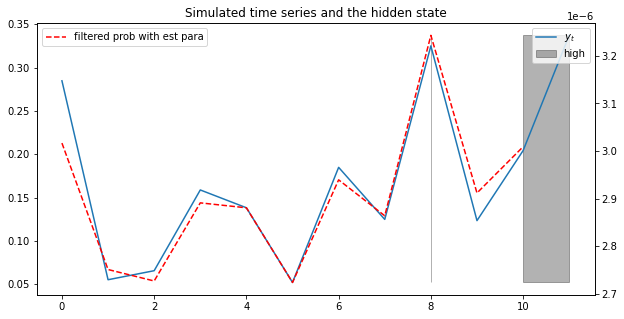

In [10]:
## plot the simulated data 
if len(fake_data_list)==1:
    random_id = 0
else:
    random_id = np.random.randint(0,len(fake_data_list)-1)
    
## get the random data and regime sequence
y = fake_data_list[random_id].T
regime_h = fake_regime_h_list[random_id]


## plot everything 

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Simulated time series and the hidden state')

## time series of y 
ax.plot(y,
         label=r'$y_t$')
## regime 
ax.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
ax2 = ax.twinx()
## filter prob
ax2.plot(filter1[random_id][:-1],
         'r--',
        label='filtered prob with est para')
ax.legend(loc=1)
ax2.legend(loc=2)

### Estimation of SCE data

In [11]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

## precision of showing float  
pd.options.display.float_format = '{:,.3f}'.format

In [12]:
## import data 
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

## variables 
vars_id = ['userid','date']
moms_nom = ['Q24_mean','Q24_iqr','Q24_var']
moms_real = ['Q24_rmean','Q24_rvar']
ue_risks = ['Q13new','Q22new']
vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'educ_gr',##education group (1-3)
                  'byear', ## year of birth
                  'tenure', ## nb of months staying in the survey 
                   'nlit'] 

vars_all_reg_long = (vars_id+moms_nom + moms_real+ue_risks+vars_demog+vars_demog_sub+vars_job)

## select dataset 
SCEM = dataset[vars_all_reg_long]


SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar',
                           'Q13new':'UE_s',
                           'Q22new':'UE_f'
                           })


SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

SCEM = SCEM.dropna(subset=['date'])

## add year and month variable 
SCEM['year'] = SCEM.date.dt.year
SCEM['month'] = SCEM.date.dt.month 


## new variables 
SCEM['age2']=SCEM['age']**2
SCEM['age3']=SCEM['age']**3
SCEM['age4']=SCEM['age']**4

## take the log 

SCEM['lrincvar'] = np.log(SCEM['rincvar'])

### some data transformation 

SCEM['UE_s'] = SCEM['UE_s']/100
SCEM['UE_f'] = SCEM['UE_f']/100

SCEM['U2U_prob'] = 1-SCEM['UE_f']   #. 1- prob of find a job
SCEM['E2E_prob'] = 1- SCEM['UE_s']*(1-SCEM['UE_f'])   ## 1- prob(loses the job and not finding one)


## trucate 0 and 1s for probs 
SCEM['U2U_prob_truc'] = SCEM['U2U_prob']
SCEM['U2U_prob_truc'] = SCEM['U2U_prob_truc'].mask(SCEM['U2U_prob_truc']>=1.0,0.99)
SCEM['U2U_prob_truc'] = SCEM['U2U_prob_truc'].mask(SCEM['U2U_prob_truc']<=0.0,0.01)


SCEM['E2E_prob_truc'] = SCEM['E2E_prob']
SCEM['E2E_prob_truc'] = SCEM['E2E_prob_truc'].mask(SCEM['E2E_prob_truc']>=1.0,0.99)
SCEM['E2E_prob_truc'] = SCEM['E2E_prob_truc'].mask(SCEM['E2E_prob_truc']<=0.0,0.01)


### transform 0-1 prob to a R 

prob_inv_func = lambda x: np.log(x)-np.log(1-x)
SCEM['U2U_prob_e'] = SCEM['U2U_prob_truc'].apply(prob_inv_func)
SCEM['E2E_prob_e'] =  SCEM['E2E_prob_truc'].apply(prob_inv_func)

In [26]:
## filter by basic/necessary criteria  
print('nb of observations before:',str(len(SCEM)))
SCEM =SCEM[SCEM['tenure']>=6]
SCEM = SCEM[SCEM['fulltime']==1]
SCEM = SCEM[SCEM['selfemp']==1]  ## working for someone 
SCEM =SCEM[(SCEM['age']<=65) & (SCEM['age']>=25) ]
SCEM =SCEM[SCEM['nlit']>=2.0]
SCEM =SCEM[SCEM['educ']>=2]
print('nb of observations after dropping low numeracy/low education sample:',str(len(SCEM)))

nb of observations before: 23866
nb of observations after dropping low numeracy/low education sample: 15702


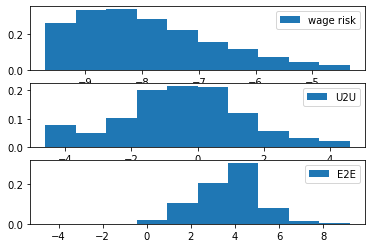

In [27]:
## first step regression

vars_list = ['lrincvar',
            'U2U_prob_e',
            'E2E_prob_e']  
var_name = ['wage risk',
            'U2U',
            'E2E']

sd_fe_list = []

fig,axes = plt.subplots(3,1)


for i,var in enumerate(vars_list):
    ## demeaned 
    SCEM[var+'_dm'] = SCEM[var]-SCEM.groupby('userid')[var].transform('mean')
    sd_fe_list.append(SCEM.groupby('userid')[var].transform('mean').std())

    ## plot initial fixed effects
    axes[i].hist(SCEM.groupby('userid')[var].transform('mean'),
                 label=var_name[i],
                 density=True)
    axes[i].legend()
    ## run a panel regression to get the residuls 
    #model = smf.ols(formula = var+'~ C(date)+C(HHinc)+C(gender)+age2+age3+age4+C(educ_gr)',
    #            data = SCEM)
    model = smf.ols(formula = var+'_dm~ C(date)',
                data = SCEM)
    result = model.fit()
    residuls = result.resid
    SCEM[var+'_rd'] = residuls

In [28]:
## correlation 
print('unconditional correlation')
SCEM[vars_list].corr()

unconditional correlation


,lrincvar,U2U_prob_e,E2E_prob_e
lrincvar,1.000,0.025,-0.094
U2U_prob_e,0.025,1.000,-0.485
E2E_prob_e,-0.094,-0.485,1.000


In [29]:
## individual fixed effects

print('std of ex-ante wage risks',sd_fe_list[0])
print('std of ex-ante U2E',sd_fe_list[1])
print('std of ex-ante E2E',sd_fe_list[2])


std of ex-ante wage risks 1.1896588802337646
std of ex-ante U2E 1.914095497808289
std of ex-ante E2E 1.4094472169761545


In [30]:
## convert the panel data of rincvar into a list of time series sequence
vars_rd_list = ['lrincvar_rd',
                'U2U_prob_e_rd',
                'E2E_prob_e_rd'
                ]

In [31]:
## correlation 
print('residual correlation')
SCEM[vars_rd_list].corr()

residual correlation


,lrincvar_rd,U2U_prob_e_rd,E2E_prob_e_rd
lrincvar_rd,1.000,0.004,-0.031
U2U_prob_e_rd,0.004,1.000,-0.356
E2E_prob_e_rd,-0.031,-0.356,1.000


In [32]:
## convert it to a list of arrays storing all time series data for each individual

SCEM_sub = SCEM[['userid']+vars_rd_list].dropna(how='any')

unique_ids = list(SCEM_sub['userid'].unique())

SCE_list = [SCEM_sub[SCEM_sub['userid']==ID][vars_rd_list].T.to_numpy() for ID in unique_ids]

SCE_list = [x for x in SCE_list if ~np.isnan(np.array(x)).any() and x.shape[1]>=3]

print('how many invidividuals have answers in successive months?',len(SCE_list))

how many invidividuals have answers in successive months? 2400


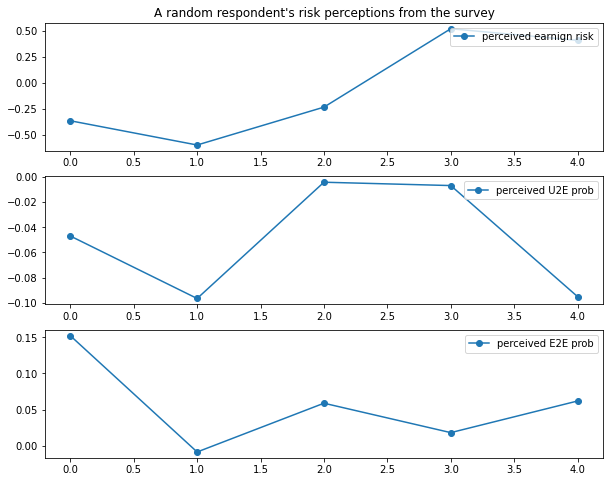

In [35]:
## plot the simulated data 
random_id = np.random.randint(0,len(SCE_list)-1)

fig, axes = plt.subplots(3,1,figsize=(10,8))
axes[0].set_title("A random respondent's risk perceptions from the survey")
axes[0].plot(SCE_list[random_id][0,:],
         'o-',
         label='perceived earnign risk')
axes[0].legend(loc=1)
axes[1].plot(SCE_list[random_id][1,:],
         'o-',
         label='perceived U2E prob')
axes[1].legend(loc=1)
axes[2].plot(SCE_list[random_id][2,:],
         'o-',
         label='perceived E2E prob')
axes[2].legend(loc=1)
fig.savefig('../Graphs/sce/markov_example.png')

In [36]:
## initialize the model based on the SCE  

AR = 1
nb_var = 1

## impose bounds on some parameters with sensible priors

## the size of the shock cannot exceed the sample variation
sigma_ub0 = np.mean([np.std(np.array(x[0,:])) for x in SCE_list])
sigma_inv_ub0 = mkv2.exp_func_inv(sigma_ub0)

sigma_ub1 = np.mean([np.std(np.array(x[1,:])) for x in SCE_list])
sigma_inv_ub1 = mkv2.exp_func_inv(sigma_ub1)

sigma_ub2 = np.mean([np.std(np.array(x[2,:])) for x in SCE_list])
sigma_inv_ub2 = mkv2.exp_func_inv(sigma_ub1)

## staying probabilities of both 2 states are above half 
q_lb = 0.5  ## persistent 
q_inv_lb = mkv2.prob_func_inv(q_lb)
p_lb = 0.5 ## persistent 
p_inv_lb = mkv2.prob_func_inv(p_lb)



if AR ==0:
    if nb_var==3:
        paras_init = np.array([0.1,0.1,0.1,0.7,0.7,
                               0.1,0.1,0.1,0.7,0.7,
                               0.1,-0.1,0.1,0.7,0.7])
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,
                0.2,0.4,-2,0.1,0.4,
                0.2,-0.1,-2,0.1,0.4])


        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),
                 (None,None),(0.0,None),(-3,sigma_inv_ub1),(None,None),(None,None),
                 (None,None),(None,0.0),(-3,sigma_inv_ub2),(None,None),(None,None),)
        
    elif nb_var ==1:
        paras_init = np.array([0.1,0.1,0.1,0.7,0.7])
        guess = np.array([0.2,0.4,-0.5,0.4,0.8])
        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),)

elif AR==1:
    if nb_var==3:
        paras_init= np.array([0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,0.1,0.1,0.7,0.7,0.8,
                              0.1,-0.1,0.1,0.7,0.7,0.9])
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,0.8,
                        0.2,0.4,-2,0.1,0.4,0.8,
                        0.2,-0.1,-2,0.1,0.4,0.8])
        
        bounds = ((None,None),(0.0,None),(-1,None),(q_lb,None),(None,None),(None,None),
                 (None,None),(0.0,None),(-3,None),(None,None),(None,None),(None,None),
                 (None,None),(None,0.0),(-3,None),(None,None),(None,None),(None,None),)
        
    elif nb_var==1:
        paras_init= np.array([0.1,0.1,0.1,0.7,0.7,0.8])
        
        guess = np.array([0.2,0.4,-0.5,0.1,0.4,0.8])
        
        bounds = ((None,None),(0.0,None),(-1,sigma_inv_ub0),(q_lb,None),(p_inv_lb,None),(None,None),)



## model instance
SCE_mkv2 = Markov2Switching(AR=AR,
                            paras=paras_init,
                            nb_var=nb_var)


## objective func
SCE_obj = lambda para: -SCE_mkv2.log_likelihood(SCE_list,
                                                para)[0]   ## only the first output

In [37]:

result = minimize(SCE_obj,
                  x0 = guess,
                  method='trust-constr',   #SLSQP
                  bounds = bounds,
                  options={'disp': True,
                            'maxiter':20000}
                   )
print('success? ',result['success'])
SCE_para_est = result['x']
## get alpha, beta, sigma, q, p 

## get model parameters 
guess_para_model = SCE_mkv2.make_para_dict(guess)
SCE_para_model_est = SCE_mkv2.make_para_dict(SCE_para_est)

#results
print("initial guess of the parameters\n",guess_para_model)
print("estimated parameters\n",SCE_para_model_est)

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 199, function evaluations: 1071, CG iterations: 482, optimality: 1.95e-03, constraint violation: 0.00e+00, execution time: 9.1e+01 s.
success?  True
initial guess of the parameters
 {'q': 0.52497918747894, 'p': 0.598687660112452, 'α': array([0.2]), 'β': array([0.4]), 'σ': array([0.60653066]), 'ϕ1': array([0.68997448])}
estimated parameters
 {'q': 0.9876190469016638, 'p': 0.5000011130946057, 'α': array([-0.04827266]), 'β': array([2.09728557]), 'σ': array([0.53551313]), 'ϕ1': array([1.79418303e-11])}


In [38]:
## get the kappa 

risks_est = pd.read_stata('../OtherData/sipp/sipp_history_vol_decomposed.dta')
## risks of permanent and transitory component 

## p/t ratio 
kappas_sipp  = risks_est['permanent']/risks_est['transitory']
kappa_sipp = np.median(kappas_sipp.dropna())
kappa = kappa_sipp ## ratio of permanent and transitory risks

print(kappa)

1.7621756968902875


In [39]:
## create a dictionary for storing QUARTERLY parameters 

model_para_q_est = {}

############################################
## from yearly to monthly risk then to quarterly
############################################

## ex-ante heterogeneity
model_para_q_est['\tilde\sigma_std'] = sd_fe_list[0]

if nb_var>1:
    model_para_q_est['\tilde \mho^l_std'] = sd_fe_list[1]
    model_para_q_est['\tilde E^l_std'] = sd_fe_list[2]
else:
    pass

## stochastic heterogeneity
model_para_q_est['q'],model_para_q_est['p'] = mkv2_M2Q(SCE_para_model_est['q'],
                                                   SCE_para_model_est['p'])

alpha = SCE_para_model_est['α'][0]
beta = SCE_para_model_est['β'][0]


model_para_q_est['\tilde\sigma_\psi^l'] = np.sqrt(3*np.exp(alpha)/(12+1/(12*kappa**2)))
model_para_q_est['\tilde\sigma_\theta^l'] =  1/3*model_para_q_est['\tilde\sigma_\psi^l']/kappa
model_para_q_est['\tilde\sigma_\psi^h'] =  np.sqrt(3*np.exp(alpha+beta)/(12+1/(12*kappa**2)))
model_para_q_est['\tilde\sigma_\theta^h'] =  1/3*model_para_q_est['\tilde\sigma_\psi^h']/kappa

if nb_var>1:
    alpha_q = SCE_para_model_est['α'][1]
    beta_q = SCE_para_model_est['α'][1]+SCE_para_model_est['β'][1]

    alpha_p = SCE_para_model_est['α'][2]
    beta_p = SCE_para_model_est['α'][2]+SCE_para_model_est['β'][2]

    model_para_q_est['\tilde \mho^l'],model_para_q_est['\tilde E^l'] = mkv2_Y2Q(SCE_mkv2.prob_func(alpha_q),
                                                                            SCE_mkv2.prob_func(alpha_p))

    model_para_q_est['\tilde \mho^h'], model_para_q_est['\tilde E^h']=  mkv2_Y2Q(SCE_mkv2.prob_func(alpha_q+beta_q),
                                                                             SCE_mkv2.prob_func(alpha_p+beta_p))

else:
    pass
print('quarterly SCE parameters\n',model_para_q_est)


## convert to a dataframe 

SCE_para_est_q_df = pd.DataFrame.from_dict(model_para_q_est,
                                         orient='index',
                                         dtype=None, 
                                         columns=['baseline']
                                        )

## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=0.3\\textwidth}
\\begin{threeparttable}
\\caption{Estimated subjective risk perceptions}
\\label{tab:PRMarkovEst}"""

endtex = """\\begin{tablenotes}\item This table reports estimates of the parameters 
for the 2-state Markov switching model of subjective risk perceptions. Risks are at the monthly frequency. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## write to latex 
f = open('../Tables/latex/PRMarkovEst.tex', 'w')
f.write(beginningtex)
tb_ltx = SCE_para_est_q_df.to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()



## presentable tables 

if nb_var>1:
    index_names = ['$std(\tilde\sigma)$',
                   '$std(\tilde\mho)$',
                   '$std(\tilde E)$',
                   '$q$',
                  '$p$',
                  '$\tilde\sigma^l_\psi$',
                  '$\tilde\sigma^l_\theta$',
                  '$\tilde\sigma^h_\psi$',
                  '$\tilde\sigma^h_\theta$',
                  '$\tilde \mho^l$',
                  '$\tilde \mho^h$',
                  '$\tilde E^l$',
                  '$\tilde E^h$']
else:
    index_names = ['$std(\tilde\sigma)$',
                   '$q$',
                  '$p$',
                  '$\tilde\sigma^l_\psi$',
                  '$\tilde\sigma^l_\theta$',
                  '$\tilde\sigma^h_\psi$',
                  '$\tilde\sigma^h_\theta$',
                  #'$\tilde \mho^l$',
                  #'$\tilde \mho^h$',
                  #'$\tilde E^l$',
                  #'$\tilde E^h$'
                   ]


SCE_para_est_q_df.index = index_names


## save it to a pickle file 
SCE_para_est_q_df.to_pickle('data/subjective_profile_est_q.pkl')

SCE_para_est_q_df


quarterly SCE parameters
 {'\tilde\\sigma_std': 1.1896588802337646, 'q': 0.9756941348780334, 'p': 0.9756941348780334, '\tilde\\sigma_\\psi^l': 0.48753147082825726, '\tilde\\sigma_\theta^l': 0.0922215024091344, '\tilde\\sigma_\\psi^h': 1.3913052720696557, '\tilde\\sigma_\theta^h': 0.2631794462048427}


,baseline
$std(\tilde\sigma)$,1.190
$q$,0.976
$p$,0.976
$\tilde\sigma^l_\psi$,0.488
$\tilde\sigma^l_\theta$,0.092
$\tilde\sigma^h_\psi$,1.391
$\tilde\sigma^h_\theta$,0.263


In [36]:
## create a dictionary for storing YEARLY parameters 

model_para_y_est = {}

############################################
## from yeraly to monthly risk
############################################

###!!!! Here you need to transform montly mkv to 1 year

## ex-ante heterogeneity
model_para_y_est['\tilde\sigma_std'] = sd_fe_list[0]

if nb_var>1:
    model_para_y_est['\tilde \mho^l_std'] = sd_fe_list[1]
    model_para_y_est['\tilde E^l_std'] = sd_fe_list[2]
else:
    pass

model_para_y_est['q'],model_para_y_est['p'] = mkv2_M2Q(SCE_para_model_est['q'],
                                                   SCE_para_model_est['p'])

alpha = SCE_para_model_est['α'][0]
beta = SCE_para_model_est['β'][0]

model_para_y_est['\tilde\sigma_\psi^l'] = np.sqrt(12*np.exp(alpha)/(12+1/(12*kappa**2)))
model_para_y_est['\tilde\sigma_\theta^l'] =  1/12*model_para_q_est['\tilde\sigma_\psi^l']/kappa
model_para_y_est['\tilde\sigma_\psi^h'] =  np.sqrt(12*np.exp(alpha+beta)/(12+1/(12*kappa**2)))
model_para_y_est['\tilde\sigma_\theta^h'] =  1/12*model_para_q_est['\tilde\sigma_\psi^h']/kappa

if nb_var>1:
    alpha_q = SCE_para_model_est['α'][1]
    beta_q = SCE_para_model_est['α'][1]+SCE_para_model_est['β'][1]

    alpha_p = SCE_para_model_est['α'][2]
    beta_p = SCE_para_model_est['α'][2]+SCE_para_model_est['β'][2]


    model_para_y_est['\tilde \mho^l'],model_para_y_est['\tilde E^l'] = SCE_mkv2.prob_func(alpha_q),SCE_mkv2.prob_func(alpha_p)

    model_para_y_est['\tilde \mho^h'], model_para_y_est['\tilde E^h']=  SCE_mkv2.prob_func(alpha_q+beta_q),SCE_mkv2.prob_func(alpha_p+beta_p)

else:
    pass

print('yearly SCE parameters\n',model_para_y_est)


## convert to a dataframe 


SCE_para_est_y_df = pd.DataFrame.from_dict(model_para_y_est,
                                         orient='index',
                                         dtype=None, 
                                         columns=['baseline']
                                        )

## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=0.3\\textwidth}
\\begin{threeparttable}
\\caption{Estimated subjective risk perceptions (yearly)}
\\label{tab:PRMarkovEst}"""

endtex = """\\begin{tablenotes}\item This table reports estimates of the parameters 
for the 2-state Markov switching model of subjective risk perceptions. Risks are at the monthly frequency. 
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## write to latex 
f = open('../Tables/latex/PRMarkovEst_y.tex', 'w')
f.write(beginningtex)
tb_ltx = SCE_para_est_y_df.to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()


## presentable tables

SCE_para_est_y_df.index = index_names


## save it to a pickle file 
SCE_para_est_y_df.to_pickle('data/subjective_profile_est_y.pkl')

SCE_para_est_y_df


yearly SCE parameters
 {'\tilde\\sigma_std': 1.2030704021453857, 'q': 0.9737703075687916, 'p': 0.9737703075687916, '\tilde\\sigma_\\psi^l': 0.9744824195987942, '\tilde\\sigma_\theta^l': 0.023041649150877894, '\tilde\\sigma_\\psi^h': 2.6618301931632913, '\tilde\\sigma_\theta^h': 0.06293900862299147}


,baseline
$std(\tilde\sigma)$,1.203
$q$,0.974
$p$,0.974
$\tilde\sigma^l_\psi$,0.974
$\tilde\sigma^l_\theta$,0.023
$\tilde\sigma^h_\psi$,2.662
$\tilde\sigma^h_\theta$,0.063


### test using macro time series: U.S.  real GDP growth rate 



In [37]:
if __name__ == "__main__":

    import pandas_datareader.data as web
    import datetime

    start = datetime.datetime(1945, 1, 1)
    end = datetime.datetime(2019, 12, 31)


    rec = web.DataReader("USREC", 
                         "fred", 
                         start, 
                         end)
    gdp = web.DataReader('GDPC1',
                         'fred',
                         start,
                         end)
    gdp_gr = gdp.pct_change().dropna()
    gdp_gr.index = pd.DatetimeIndex(gdp_gr.index, freq="QS")

In [30]:
if __name__ == "__main__":

    ## use statsmodels 

    mod_hamilton = sm.tsa.MarkovAutoregression(
        gdp_gr, 
        k_regimes=2, 
        order= 4, 
        switching_ar=False
    )
    res_hamilton = mod_hamilton.fit()

In [31]:
if __name__ == "__main__":
    res_hamilton.summary()

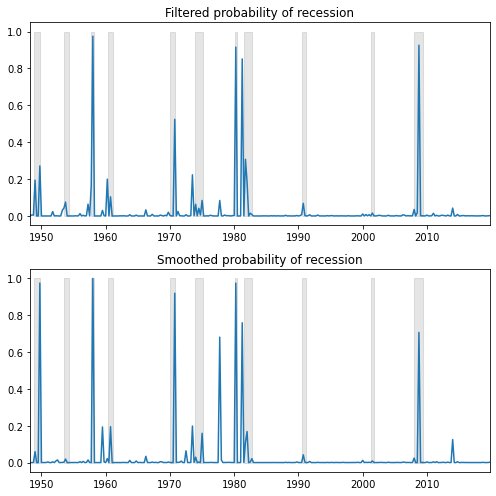

In [32]:
if __name__ == "__main__":


    fig, axes = plt.subplots(2, figsize=(7, 7))
    ax = axes[0]
    ax.plot(res_hamilton.filtered_marginal_probabilities[0])
    ax.fill_between(rec.index, 
                    0, 
                    1, 
                    where=rec["USREC"].values, 
                    color="k", 
                    alpha=0.1)
    ax.set_xlim(gdp_gr.index[4], gdp_gr.index[-1])
    ax.set(title="Filtered probability of recession")

    ax = axes[1]
    ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
    ax.fill_between(rec.index, 0, 1, where=rec["USREC"].values, color="k", alpha=0.1)
    ax.set_xlim(gdp_gr.index[4], gdp_gr.index[-1])
    ax.set(title="Smoothed probability of recession")

    fig.tight_layout()

In [33]:
if __name__ == "__main__":


    ## estimation using codes here 

    mkv2_gdp = Markov2Switching(AR=1,
                               nb_var=1)
    fake_data_list = [np.array(gdp_gr['GDPC1'])]

    obj = lambda para: -mkv2_gdp.log_likelihood(fake_data_list,
                                            para)[0]   ## only the first output

    ## estimation 
    guess = (0.0,0.2,0.4,0.2,0.2,0.9)
    #bounds = [(None,None),(None,None),(0.03,1.0),(0.0,1.0),(0.0,1.0)] 

    para_est = minimize(obj,
                        x0=guess,
                        method='CG',
                        options={'disp': True,
                                #'maxls':40,
                                #'ftol': 2.220446049250313e-11
                                }
                       )['x']

    #results
    print('Estimated model parameters:',[round(x,2) for x in mkv2_gdp.get_model_para(para_est)])

    llh,filter1,pr1,pdf = mkv2_gdp.log_likelihood(fake_data_list,
                                              para_est)

AssertionError: the nb of parameters needs to be equal to 6 x nb of variables

In [ ]:
if __name__ == "__main__":


    ## plot the time series 

    lw = 2
    figsize = (15,5)
    fontsize = 10

    ## plot 
    fig, ax = plt.subplots(figsize = figsize)
    ax2 = ax.twinx()
    ax.plot(gdp_gr.index[2:-1],
            gdp_gr[2:-1],
            color='black',
               lw= lw,
               label= 'gdp growth ')
    ax2.plot(gdp_gr.index[2:-1],
             filter1[0][2:-1],
             'r-',
             lw = lw,
             label = 'filter prob (RHS)')
    ax.legend(loc = 2,
             fontsize = fontsize)
    ax.set_xlabel("month",fontsize = fontsize)
    ax.grid()
    ax.set_ylabel('% growth',fontsize = fontsize)
    ax.tick_params(axis='both', 
                   which='major', 
                   labelsize = fontsize)
    ax2.tick_params(axis='both', 
                   which='major', 
                   labelsize = fontsize)
    ax2.fill_between(rec.index, 
                    min(filter1[0][1:-1]), 
                    max(filter1[0][1:-1]), 
                    where=rec["USREC"].values, 
                    color="k", 
                    alpha=0.1)
    ax2.legend(loc = 1,
              fontsize = fontsize)